<a href="https://colab.research.google.com/github/elifsenakuru/face_recognition1/blob/main/facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
! pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json



In [ ]:
!kaggle datasets download -d msambare/fer2013

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip fer2013.zip

Archive:  fer2013.zip
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_dir = '/content/train/'
test_dir = '/content/test/'

In [ ]:
img_size = 48

In [ ]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [ ]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
    
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

        sad  neutral  surprise  disgust  fear  happy  angry
train  4830     4965      3171      436  4097   7215   3995
       sad  neutral  surprise  disgust  fear  happy  angry
test  1247     1233       831      111  1024   1774    958


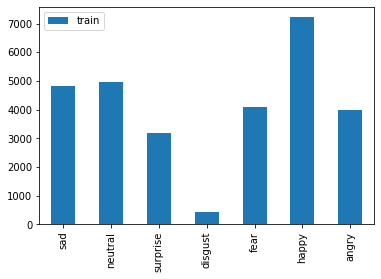

In [ ]:
train_count.transpose().plot(kind='bar')



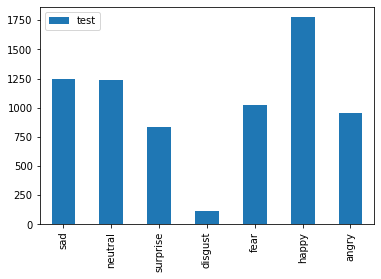

In [ ]:
test_count.transpose().plot(kind='bar')

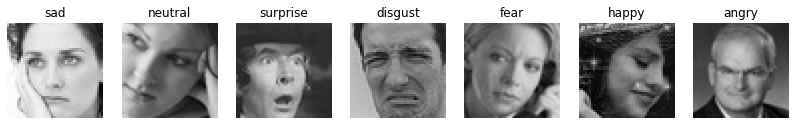

In [ ]:

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[2]))
    plt.subplot(1,7,i)
    plt.imshow(img)    
    plt.title(expression)
    plt.axis('off')
    i += 1

plt.show()



In [ ]:
train_generator.class_indices



{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
from keras.preprocessing import image
img = image.load_img("/content/test/angry/PrivateTest_10131363.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [ ]:


# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False



In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:


# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))



In [ ]:
input_shape = (48,48,3)
output_class = 7


In [ ]:


model2 = Sequential()

model2.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128,(5,5), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(256,(3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(512,(3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(256))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))

model2.add(Dense(512))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))

model2.add(Dense(7, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_16 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
import math

In [ ]:
batch_size = 64
trainingSize = 22968
validateSize = 1432

def calculate_spe(y):
  return int(math.ceil((1. * y) / batch_size)) 

In [ ]:
steps_per_epoch = calculate_spe(trainingSize)
validation_steps = calculate_spe(validateSize)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

hist = model2.fit(x=train_generator,
                 validation_data=validation_generator,
                 epochs=15,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)



Epoch 1/15
359/359 [==============================] - 792s 2s/step - loss: 1.8669 - accuracy: 0.2573 - val_loss: 1.9342 - val_accuracy: 0.2737
Epoch 2/15
359/359 [==============================] - 789s 2s/step - loss: 1.6285 - accuracy: 0.3645 - val_loss: 1.5809 - val_accuracy: 0.3834
Epoch 3/15
359/359 [==============================] - 788s 2s/step - loss: 1.4550 - accuracy: 0.4396 - val_loss: 1.3450 - val_accuracy: 0.4839
Epoch 4/15
359/359 [==============================] - 784s 2s/step - loss: 1.3558 - accuracy: 0.4822 - val_loss: 1.3332 - val_accuracy: 0.4930
Epoch 5/15
359/359 [==============================] - 785s 2s/step - loss: 1.2918 - accuracy: 0.5055 - val_loss: 1.3590 - val_accuracy: 0.4902
Epoch 6/15
359/359 [==============================] - 783s 2s/step - loss: 1.2533 - accuracy: 0.5230 - val_loss: 1.3338 - val_accuracy: 0.5014
Epoch 7/15
359/359 [==============================] - 788s 2s/step - loss: 1.2214 - accuracy: 0.5341 - val_loss: 1.3793 - val_accuracy: 0.4839

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
model.save('face_emotion')

In [ ]:
model = tf.keras.models.load_model('/content/face_emotion')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model.save(path)